In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import torch
import json
import time
from sklearn.linear_model import LinearRegression
import os
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [2]:
exps = {
    "baseline": "Baseline",
    "elr": "ELR",
    "selective": "Selective Loss"
}

In [3]:
# Train Epoch: (\d+) $$ ?\d+/\d+ $(\d+)%$$$
# image_to_text_mean_rank: ([\d.]+)\simage_to_text_median_rank: ([\d.]+)\simage_to_text_R@1: ([\d.]+)\simage_to_text_R@5: ([\d.]+)\simage_to_text_R@10: ([\d.]+)\stext_to_image_mean_rank: ([\d.]+)\stext_to_image_median_rank: ([\d.]+)\stext_to_image_R@1: ([\d.]+)\stext_to_image_R@5: ([\d.]+)\stext_to_image_R@10: ([\d.]+)\sclip_val_loss: ([\d.]+).*val_generative_loss: ([\d.]+)


# Just Normal Output Logs

In [5]:
# Training
contrastive_loss = {exp: [] for exp in exps}
caption_loss = {exp: [] for exp in exps}

# Eval
clip_loss = {exp: [] for exp in exps}
generative_loss = {exp: [] for exp in exps}
rank_keys = ["mean", "median", "1", "5", "10"]
img_text_metrics = {f"img_text_{rk}": {exp: [] for exp in exps} for rk in rank_keys}
text_img_metrics = {f"text_img_{rk}": {exp: [] for exp in exps} for rk in rank_keys}
imagenet_metrics = {f"top{rk}": {exp: [] for exp in exps} for rk in [1, 5]}

In [6]:
def read_out_log(file_path, exp):
    with open(file_path, "r") as f:
        lines = f.readlines()
        for i in range(len(lines)):
            if "(100%)" in lines[i] and "Train" in lines[i]:
                losses = re.search(r"Contrastive_loss: ([\d.]+).*Caption_loss: ([\d.]+)", lines[i])
                contrastive_loss[exp].append(int(losses.group(1)))
                caption_loss[exp].append(int(losses.group(2)))
            elif "@" in lines[i]:
                if not eval_losses:
                    print("Darn")
                    print(lines[i])
                for rk in rank_keys:
                    if rk.isnumeric():
                        img_text_metrics[f"img_text_{rk}"][exp].append(int(re.search(r"image_to_text_R@{}: ([\d.]+)".format(rk), lines[i]).group(1)))
                        text_img_metrics[f"text_img_{rk}"][exp].append(int(re.search(r"text_to_image_R@{}: ([\d.]+)".format(rk), lines[i]).group(1)))
                    else:
                        img_text_metrics[f"img_text_{rk}"][exp].append(int(re.search(r"image_to_text_{}_rank: ([\d.]+)".format(rk), lines[i]).group(1)))
                        text_img_metrics[f"text_img_{rk}"][exp].append(int(re.search(r"text_to_image_{}_rank: ([\d.]+)".format(rk), lines[i]).group(1)))
                clip_loss[exp].append(int(re.search(r"clip_val_loss: ([\d.]+)", lines[i]).group(1)))
                generative_loss[exp].append(int(re.search(r"val_generative_loss: ([\d.]+)", lines[i]).group(1)))
                if "imagenet" in lines[i]:
                    for rk in [1, 5]:
                        imagenet_metrics[f"top{rk}"][exp].append(int(re.search(r"-val-top{}: ([\d.]+)".format(rk), lines[i]).group(1)))


In [7]:
# Read in here

# Looking at Samples

In [9]:
checkpoints = np.arange(10, 101, 10)
num_samples = 64
seq_length = 75

In [4]:
start = time.time()
eval_data = {exp: {chkpt: None for chkpt in checkpoints} for exp in exps}
for exp in exps:
    for chkpt in checkpoints:
        with open(f"eval_logs/{exp}/checkpoint_{chkpt}_metrics.json", "r") as f:
            eval_data[exp][chkpt] = json.loads(f.read())
end = time.time()
print("Main metrics reading time:", round((end - start) / 60, 2))

Main metrics reading time: 20.91


In [5]:
start = time.time()
sub_data = {exp: {chkpt: None for chkpt in checkpoints} for exp in exps}
for exp in exps:
    for chkpt in checkpoints:
        with open(f"eval_logs/{exp}/checkpoint_{chkpt}_submetrics.json", "r") as f:
            sub_data[exp][chkpt] = json.loads(f.read())
end = time.time()
print("Sub metrics reading time:", round((end - start) / 60, 2))

Sub metrics reading time: 2.46


In [23]:
# Dictionary keys:
# 'saved_epoch'
# 'all_loss', 'all_gen_loss'
# 'all_labels', 'all_logits', 'all_logit_scales', 'all_predictions'
# 'all_per_position_losses', 'all_per_token_losses'

## Generative loss over time

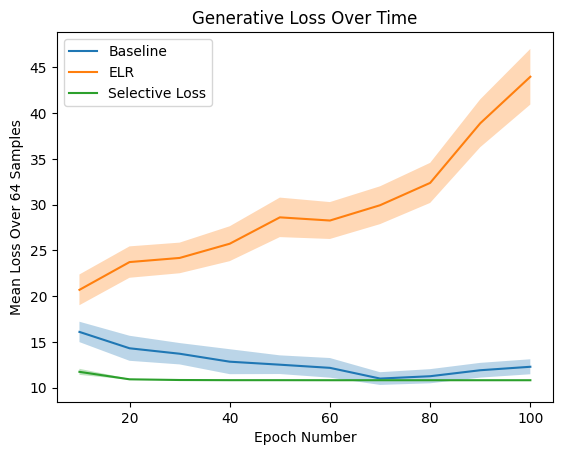

In [11]:
plt.figure()

for exp in exps:
    gen_losses = np.array([eval_data[exp][chkpt]["all_gen_loss"] for chkpt in checkpoints])
    mean_losses = np.mean(gen_losses, axis = 1)
    plt.plot(checkpoints, mean_losses, label = exps[exp])
    std_losses = np.std(gen_losses, axis = 1)
    plt.fill_between(checkpoints, mean_losses - std_losses, mean_losses + std_losses, alpha = 0.3)

plt.title("Generative Loss Over Time")
plt.xlabel("Epoch Number")
plt.ylabel("Mean Loss Over 64 Samples")
plt.legend()
plt.show()

## Average per position loss at last epoch

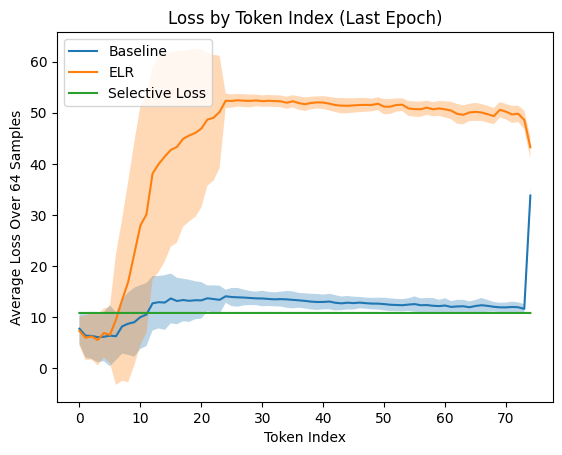

In [22]:
coi = 100
plt.figure()

for exp in exps:
    ppl = np.array(eval_data[exp][coi]["all_per_position_losses"])
    avg_ppl = np.mean(ppl, axis = 0)
    plt.plot(range(seq_length), avg_ppl, label = exps[exp])
    std_ppl = np.std(ppl, axis = 0)
    plt.fill_between(range(seq_length), avg_ppl - std_ppl, avg_ppl + std_ppl, alpha = 0.3)

plt.title("Loss by Token Index (Last Epoch)")
plt.xlabel("Token Index")
plt.ylabel("Average Loss Over 64 Samples")
plt.legend()
plt.show()

## H/L token categories

In [28]:
threshold = 0.2
cats = ["H→H", "H→L", "L→H", "L→L"]

def classify_token_losses(exp):
    initial_losses = eval_data[exp][10]["all_per_token_losses"]
    final_losses = eval_data[exp][100]["all_per_token_losses"]
    vocab = initial_losses.keys()
    L_mean = np.mean([loss for loss in final_losses.values()])

    categories = {cat: [] for cat in cats}
    loss_tracker = {cat: [[] for _ in range(len(checkpoints))] for cat in cats}
    avg_losses = {cat: [0 for _ in range(len(checkpoints))] for cat in cats}
    std_losses = {cat: [0 for _ in range(len(checkpoints))] for cat in cats}
    for token in vocab:
        losses = np.array([eval_data[exp][chkpt]["all_per_token_losses"][token] for chkpt in checkpoints])
        model = LinearRegression().fit(checkpoints.reshape(-1, 1), losses)
        a = model.coef_[0]
        b = model.intercept_
        L_start = b
        L_end = a * 10 + b  # 10 checkpoints
        delta_L = L_end - L_start
        if delta_L < -threshold:
            cat = "H→L"
        elif delta_L > threshold:
            cat = "L→H"
        elif -threshold <= delta_L <= threshold:
            if losses[-1] <= L_mean:
                cat = "L→L"
            else:
                cat = "H→H"
        categories[cat].append(token)
        for i in range(len(losses)):
            loss_tracker[cat][i].append(losses[i])
    for cat in cats:
        for i in range(len(checkpoints)):
            mean, avg = np.mean(loss_tracker[cat][i]), np.std(loss_tracker[cat][i])
            avg_losses[cat][i] = mean
            std_losses[cat][i] = avg
    return categories, loss_tracker, avg_losses, std_losses

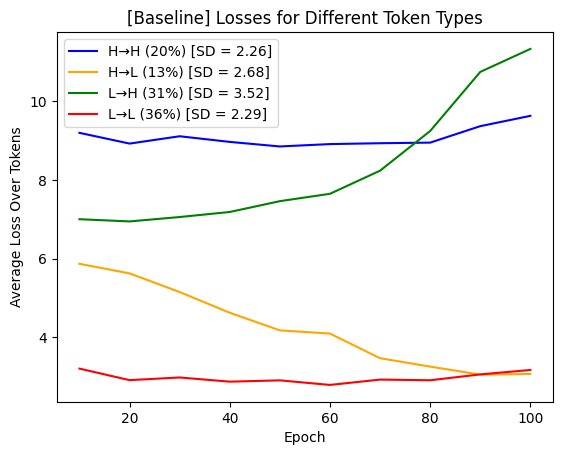

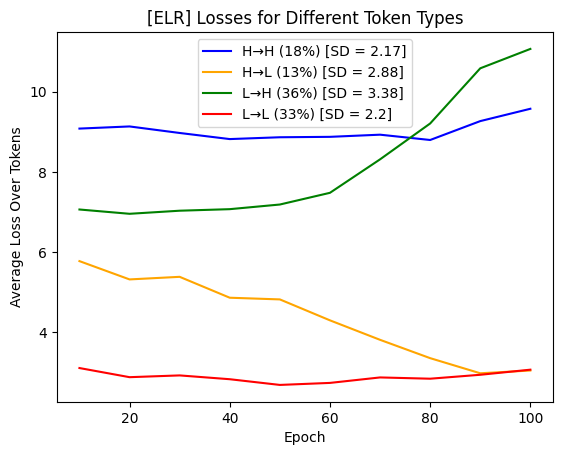

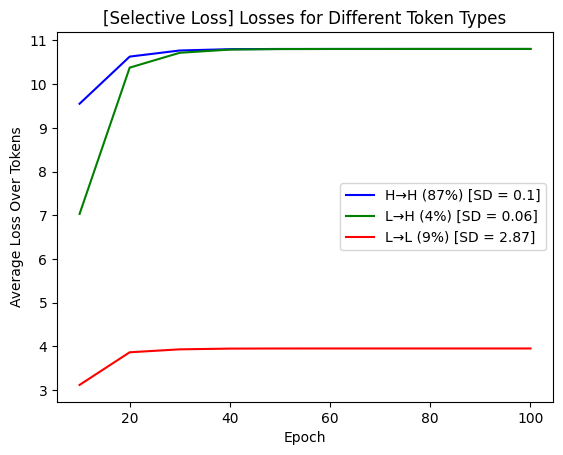

In [34]:
colors = ["blue", "orange", "green", "red"]
cat_colors = {cats[i]: colors[i] for i in range(4)}
for exp in exps:
    plt.figure()
    loss_categories, loss_tracker, avg_losses, std_losses = classify_token_losses(exp)
    vocab_size = sum([len(loss_categories[cat]) for cat in loss_categories])
    for cat in cats:
        if len(loss_categories[cat]) > 0:
            plt.plot(checkpoints, avg_losses[cat],
                     label = f"{cat} ({round(len(loss_categories[cat]) / vocab_size * 100)}%) [SD = {round(np.mean(std_losses[cat]), 2)}]",
                     color = cat_colors[cat])
            # avg_losses[cat], std_losses[cat] = np.array(avg_losses[cat]), np.array(std_losses[cat])
            # plt.fill_between(checkpoints, avg_losses[cat] + std_losses[cat], avg_losses[cat] - std_losses[cat], alpha = 0.2, color = cat_colors[cat])
    plt.title(f"[{exps[exp]}] Losses for Different Token Types")
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss Over Tokens")
    plt.legend()
    plt.show()

## Top five lossiest tokens for each model at epochs 10, 50, and 100

## Run through three captioning examples per model at epochs 10, 50, and 100

In [47]:
sample_dir = "./eval_samples/"
sample_samples = [21, 42, 63]
samples = os.listdir(sample_dir)
for idx in sample_samples:
    print("Looking at sample number", idx)
    with open(f"{sample_dir}cap_{idx}.txt", "r") as f:
        caption = f.read().strip()
    print("Ground truth caption:", caption)
    for exp in exps:
        log = f"{exps[exp]} model:\n"
        for chkpt in [100]:
            log += f"{chkpt}. {eval_data[exp][chkpt]['all_predictions'][idx]}\n"
        print(log + "\n")

Looking at sample number 21
Ground truth caption: even during the winter months , there is plenty to see , do and admire outside .
Baseline model:
100. the  though  the  storm  |  ,  the  's  a  of  go  why  because  not  take  the  .  <end_of_text> version  /  ™  [  [  ™  ™  ®  ®  ®  ®  }  }  ​  ​  ​  ​  he he he . he he he he he }  must  must  must  must  must  must  must  must  must  must  must  must  must  #  #  must  #  must  #  #  must  must  ston  #  #  #  #  #  #  <end_of_text>


ELR model:
100. the  the  the  cold  it  ,  i  is  a  of  discover  and  a  !  see  .  ,  <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_text> <end_of_tex

## Attending to text or to image?

In [28]:
with open(f"eval_logs/elr/checkpoint_100_metrics.json", "r") as f:
    test = json.loads(f.read())

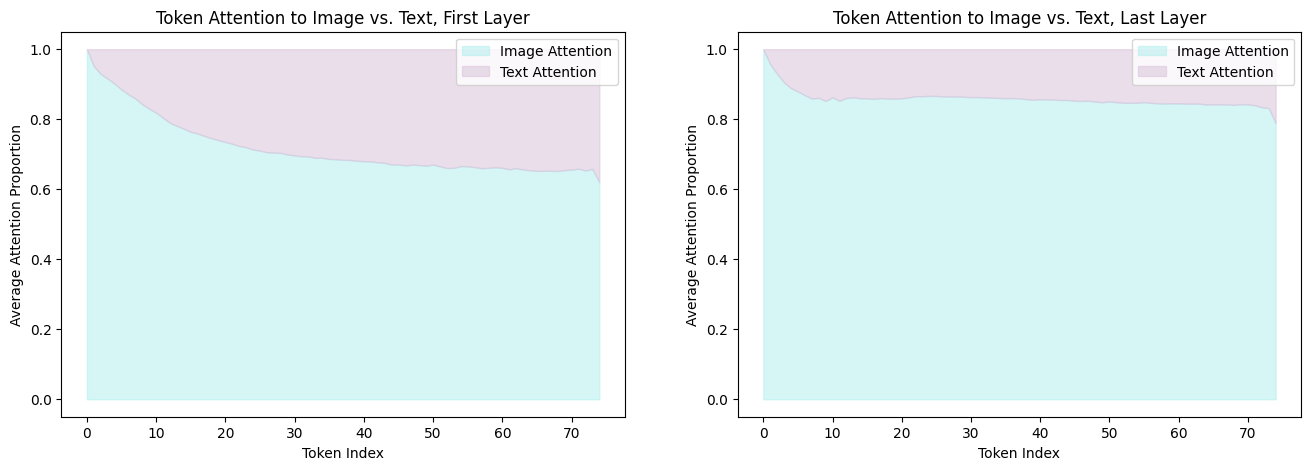

In [43]:
fig, axes = plt.subplots(1, 2, figsize = (16, 5))
indices = np.arange(seq_length)
layers = ["0", "11"]

for i in range(len(layers)):
    avg_img_attn_ratios = np.zeros(seq_length)
    avg_text_attn_ratios = np.zeros(seq_length)
    for j in range(num_samples):
        token_attn_split = test["all_token_attn_splits"][j]
        img_attn, text_attn = token_attn_split[layers[i]]
        avg_img_attn_ratios += np.array(img_attn)
        avg_text_attn_ratios += np.array(text_attn)
    avg_img_attn_ratios = avg_img_attn_ratios / num_samples
    avg_text_attn_ratios = avg_text_attn_ratios / num_samples

    axes[i].fill_between(indices, 0, avg_img_attn_ratios, color = "paleturquoise", alpha = 0.5, label = "Image Attention")
    axes[i].fill_between(indices, avg_img_attn_ratios, avg_img_attn_ratios + avg_text_attn_ratios, color = "thistle", alpha = 0.5, label = "Text Attention")
    layer_name = "First Layer" if layers[i] == "0" else "Last Layer"
    axes[i].set_title(f"Token Attention to Image vs. Text, {layer_name}")
    axes[i].set_xlabel("Token Index")
    axes[i].set_ylabel("Average Attention Proportion")
    axes[i].legend()
plt.show()